Anomaly detection for drifting buoy data is challenging because the data characteristics depend on many factors: reporting frequency, position error, 

In [23]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import sys
sys.path.append('../../drifter')
from importlib import reload
import os
import utilities.cleaning as clean
import utilities.interpolation as interp
import proplot as pplt
clean = reload(clean)
interp = reload(interp)

In [39]:
dataloc = '../../data/adc_dn_tracks/'
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]

# Optional: focus in on only a portion of the tracks
begin = '2019-10-15-00 00:00'
end = '2022-01-01 00:00'
    
file_present = np.array([f + '.csv' in files for f in metadata.filename])
metadata = metadata.loc[file_present].copy()
metadata.set_index('Sensor ID', inplace=True)

# Maximum gap in hours for the interpolation algorithm
max_dt = 2

# Pad for interpolation, so that the first and last values aren't missing.
margin = pd.to_timedelta('6H')
buoy_data = {}
for file in metadata.filename:
    sensorweb_id = file.split('_')[-1]
    buoy_data[file.replace('.csv', '').split('_')[-1]] = pd.read_csv(dataloc + file + '.csv',
                                            index_col='datetime', parse_dates=True)


In [44]:
for buoy in buoy_data:
    data = buoy_data[buoy].copy()

    data['flag_dup'] = clean.flag_duplicates(data, date_index=True)
    data['flag_date'] = clean.check_dates(data, date_index=True)
    data['flag_speed'] =  clean.check_speed(data.copy(), date_index=True, method='z-score', sigma=6, window='3D')
    #data = data.where(~(check_dup | check_dates)).dropna()
    data = clean.compute_speed(data, date_index=True, difference='backward')    
    #data['speed_flag'] = clean.check_speed(data, date_index=True, method='z-score', sigma=6, window='3D')

    buoy_data[buoy] = data #data.where(~data.speed_flag).dropna()



In [19]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [95]:
# Start with only a small number of outliers
for buoy in buoy_data:
    buoy_data[buoy]['outlier'] = False
    data = buoy_data[buoy]
    fwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='forward')['speed']   
    bwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='backward')['speed']   
    speed = pd.DataFrame({'b': bwd_speed, 'f': fwd_speed}).min(axis=1)
    buoy_data[buoy]['speed_bf'] = speed


In [200]:
def dist_from_median(xvar, yvar, data, window):
    """Computes the distance of the point from the median of a moving window."""
    xa = data[xvar] - data[xvar].rolling(window, center=True).median()
    ya = data[yvar] - data[yvar].rolling(window, center=True).median()
    
    return np.sqrt(xa**2 + ya**2)

<AxesSubplot:xlabel='datetime'>

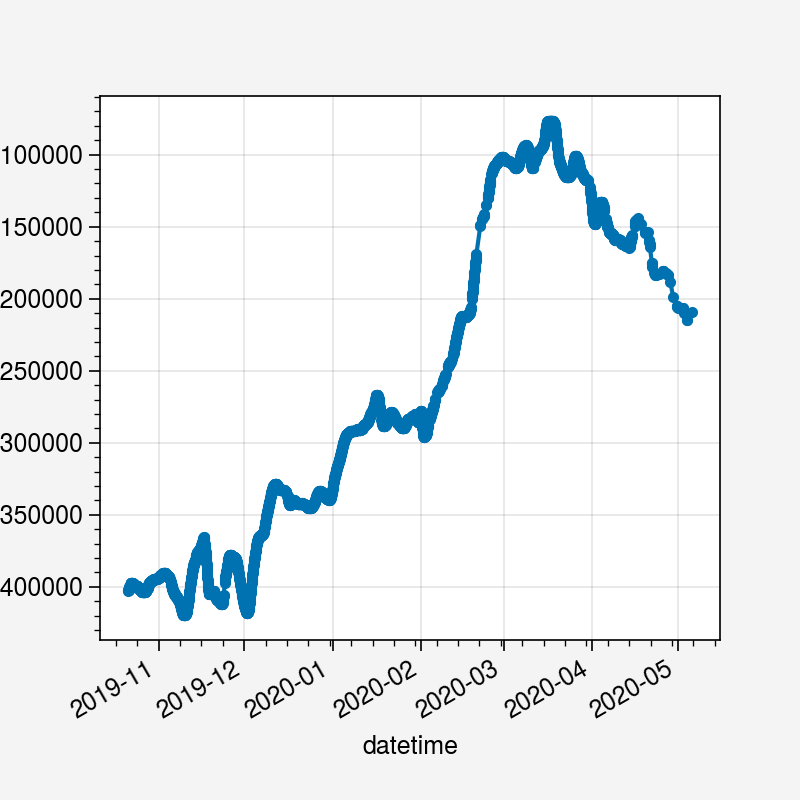

In [89]:
# Example outliers
# timeslice = slice('2020-04-23', '2020-04-24')
# buoy_data['2019R9'].x.loc[timeslice].plot(marker='.')

# timeslice = slice('2020-04-23', '2020-04-24')
buoy_data['2019P151'].x.loc[timeslice].plot(marker='.')

In [64]:
buoy_data['2019R9'].loc['2020-04-23 11:01:09', 'outlier'] = True

In [165]:
# Constructing variables
buoy = '2019R9'
#buoy = '2019P151'
data = buoy_data[buoy].copy()
var_dict = {}
for variable in ['x', 'y', 'speed_bf']:
    var_dict[variable + '_anomaly_3n'] = data[variable] - data[variable].rolling(3, center=True).median()
    var_dict[variable + '_anomaly_6H'] = data[variable] - data[variable].rolling('6H', center=True).median()
    var_dict[variable + '_zscore_3D'] = (data[variable] - data[variable].rolling('3D', center=True).mean())/data[variable].rolling('3D', center=True).std()
    var_dict[variable + '_zscore_12D'] = (data[variable] - data[variable].rolling('12D', center=True).mean())/data[variable].rolling('3D', center=True).std()
var_dict['outlier'] = data['outlier'].astype(int)

In [166]:
test_df = pd.DataFrame(var_dict)
test_df['xy_zscore_3D'] = test_df[['x_zscore_3D', 'y_zscore_3D']].max(axis=1)
test_df['xy_zscore_12D'] = test_df[['x_zscore_12D', 'y_zscore_12D']].max(axis=1)
test_df['xy_anomaly_3n'] = test_df[['x_anomaly_3n', 'y_anomaly_3n']].max(axis=1)
test_df['xy_anomaly_6H'] = test_df[['x_anomaly_6H', 'y_anomaly_6H']].max(axis=1)


<AxesSubplot:xlabel='datetime'>

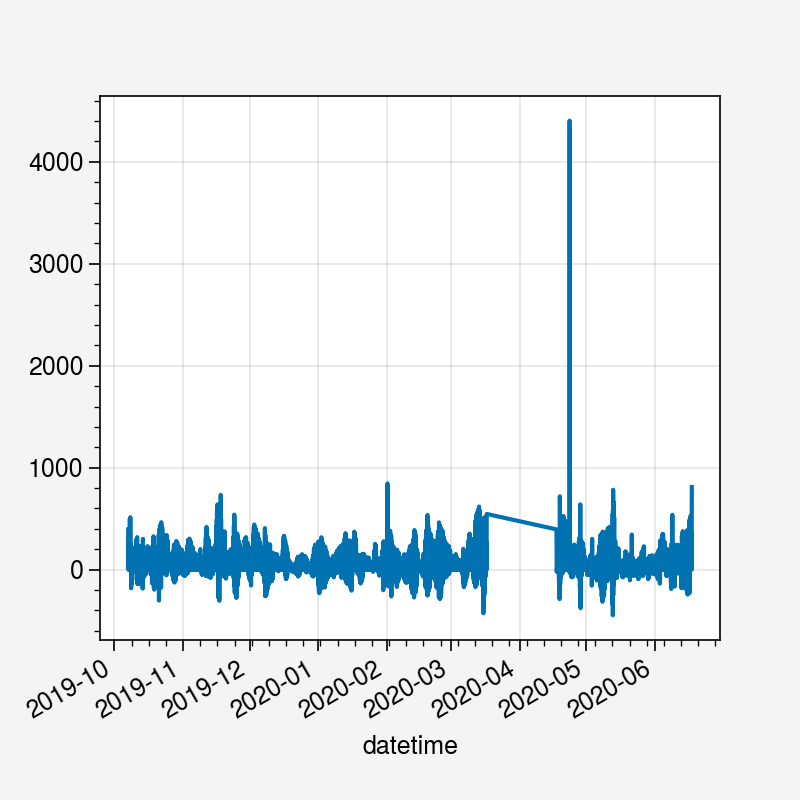

In [199]:
test_df[['x_anomaly_6H', 'y_anomaly_6H']].max(axis=1).plot()

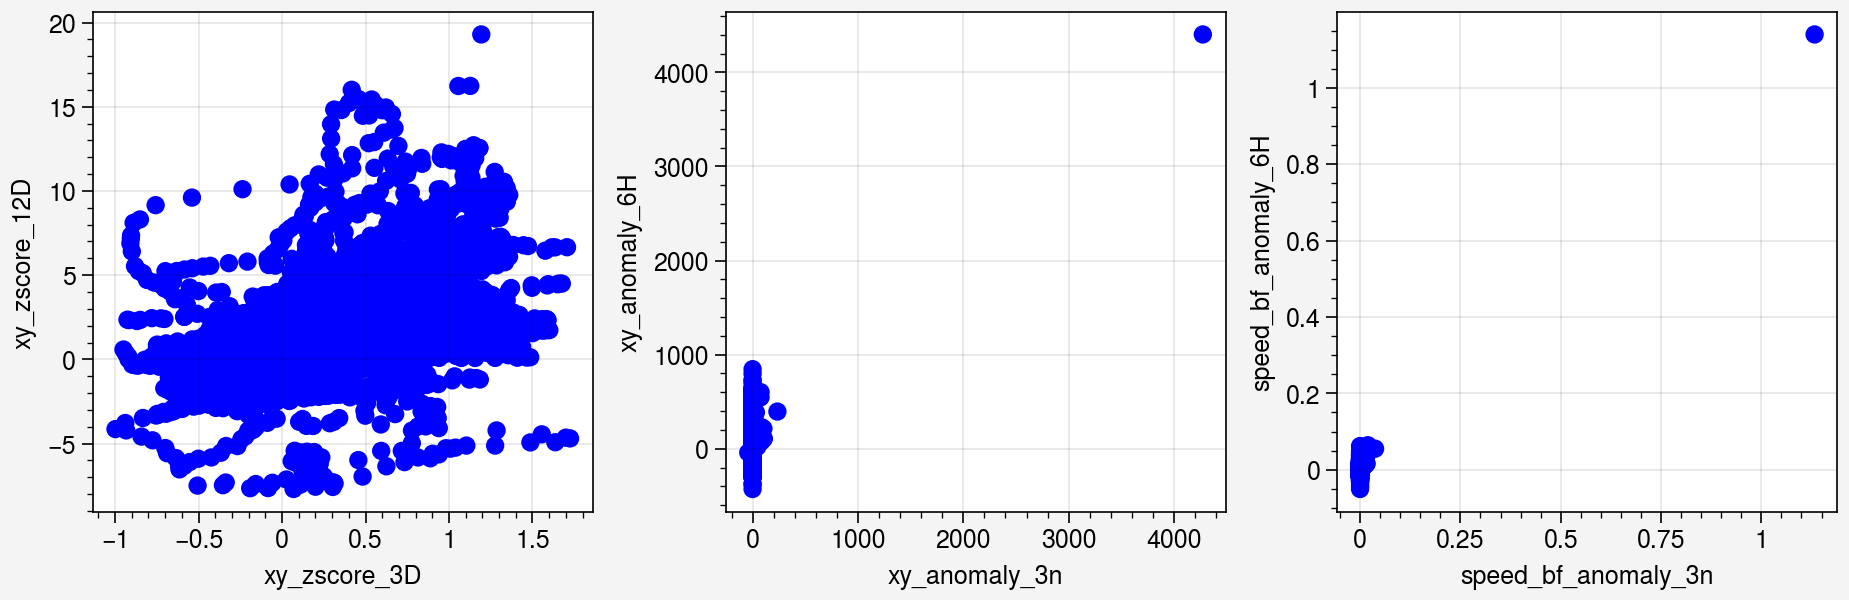

In [168]:
fig, ax = pplt.subplots(ncols=3, share=False)
timeslice=slice('2019-01-01', '2020-05-05')
ax[0].scatter(x='xy_zscore_3D', y='xy_zscore_12D', c='outlier', cmap='bwr', data=test_df.loc[timeslice])
ax[1].scatter(x='xy_anomaly_3n', y='xy_anomaly_6H', c='outlier', cmap='bwr', data=test_df.loc[timeslice])
ax[2].scatter(x='speed_bf_anomaly_3n', y='speed_bf_anomaly_6H', c='outlier', cmap='bwr', data=test_df.loc[timeslice])

In [169]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [170]:
test_df.head()

,x_anomaly_3n,x_anomaly_6H,x_zscore_3D,x_zscore_12D,y_anomaly_3n,y_anomaly_6H,y_zscore_3D,y_zscore_12D,speed_bf_anomaly_3n,speed_bf_anomaly_6H,speed_bf_zscore_3D,speed_bf_zscore_12D,outlier,xy_zscore_3D,xy_zscore_12D,xy_anomaly_3n,xy_anomaly_6H
datetime,,,,,,,,,,,,,,,,,
2019-10-07 06:01:42,NaN,-73.216724,-1.402079,2.640096,NaN,393.614205,1.421903,2.518322,NaN,0.002411,-1.040573,0.169871,0,1.421903,2.640096,NaN,393.614205
2019-10-07 06:46:08,0.0,-25.791796,-1.363480,2.716417,0.0,141.971774,1.383533,2.480558,0.0,0.004821,-1.040573,0.172887,0,1.383533,2.716417,0.0,141.971774
2019-10-07 07:05:15,0.0,-26.757153,-1.335066,2.787504,0.0,202.593088,1.383965,2.427814,0.0,-0.001122,-1.081149,0.099294,0,1.383965,2.787504,0.0,202.593088
2019-10-07 08:02:12,0.0,26.757153,-1.277575,2.864709,0.0,-202.593088,1.354449,2.348790,0.0,-0.002870,-1.079182,0.073213,0,1.354449,2.864709,0.0,26.757153
2019-10-07 09:01:54,0.0,0.000000,-1.210155,2.924448,0.0,0.000000,1.324380,2.272757,0.0,-0.003993,-1.047945,0.073295,0,1.324380,2.924448,0.0,0.000000


In [191]:
#centers = [[1, 1], [-1, -1], [1, -1]]
#X, labels_true = make_blobs(
#    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
#)

X = test_df.loc[timeslice,['xy_anomaly_3n', 'xy_anomaly_6H', 'xy_zscore_12D', 'speed_bf_anomaly_3n']].dropna()
index = X.index
X = X.values

X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=2, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
# )
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))


Estimated number of clusters: 2
Estimated number of noise points: 0


In [192]:
X[:,3]

array([-0.12143767, -0.11550783, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.10677168, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.0941867 , -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.01700324, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143509, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.11506102, -0.12143767,
       -0.12143767, -0.12143767, -0.12023361, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767,  8.42540359,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.12143767,
       -0.12143767, -0.12143767, -0.12143767, -0.12143767, -0.08

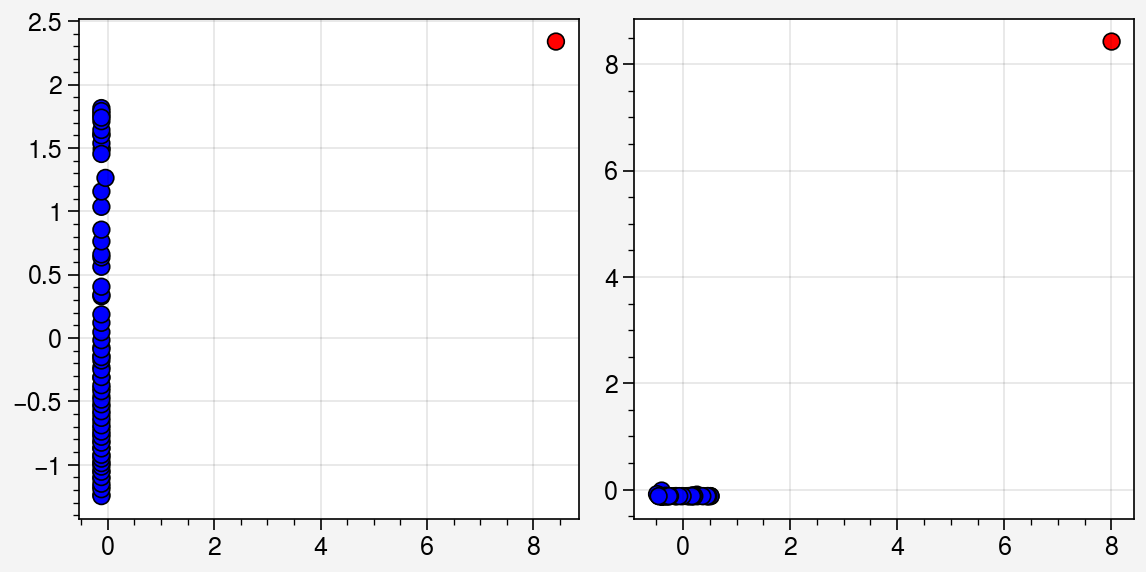

In [193]:
fig, axs = pplt.subplots(ncols=2, share=False)
axs[0].scatter(X[:,0], X[:,2], c=labels, edgecolor='k', cmap='bwr')
axs[1].scatter(X[:,1], X[:,3], c=labels, edgecolor='k', cmap='bwr')

In [194]:
buoy_data[buoy].loc[index].loc[labels==1]

,latitude,longitude,flag_dup,flag_date,flag_speed,x,y,u,v,speed,speed_flag,outlier,speed_bf
datetime,,,,,,,,,,,,,
2020-04-23 11:01:09,84.0837,16.63491,False,False,True,-189082.192326,632854.943701,-0.181787,1.280185,1.293028,False,False,1.182347


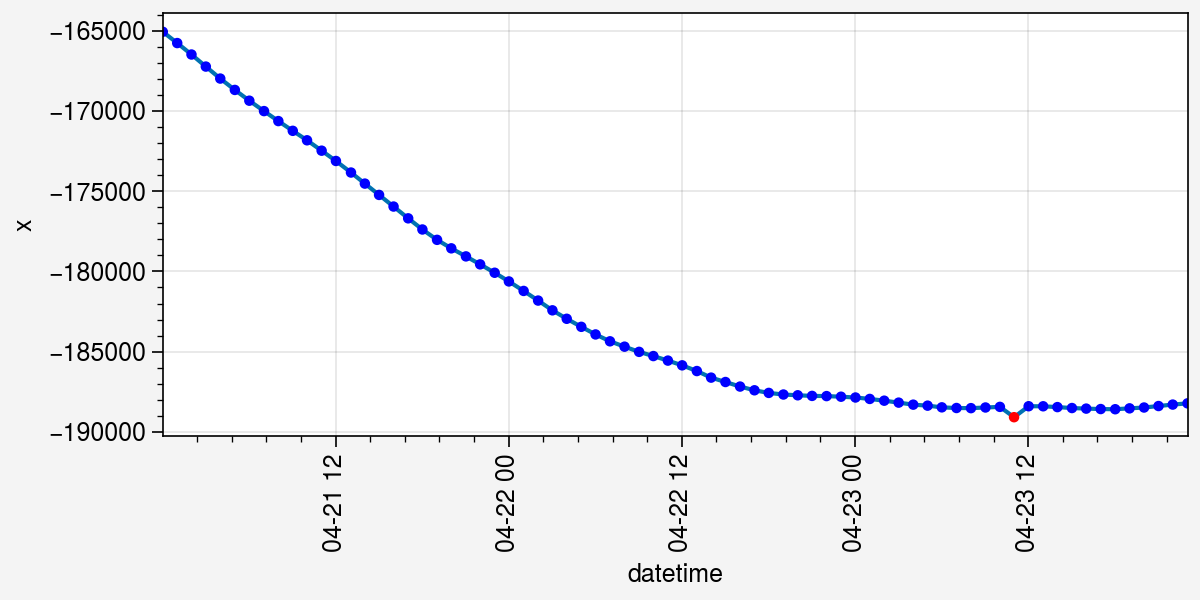

In [195]:
timeslice = slice('2020-04-21', '2020-04-23')
data = buoy_data[buoy].loc[index]
data['class'] = labels
data = data.loc[timeslice]

fig, ax = pplt.subplots(width=6, height=3)
ax.plot(data.index, data.loc[:, 'x'], zorder=0)
ax.scatter(data.index, data.loc[:, 'x'], c=data['class'], cmap='bwr', markersize=10)

In [136]:
buoy_data[buoy].loc[timeslice].shape

(3820, 13)

In [137]:
len(labels)

3818